Подключим все необходимые библиотеки, включая самописные utils и net

In [1]:
import os
import sys
import time
import numpy as np
from tqdm import tqdm, trange

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.autograd import Variable
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
from torchvision import models

from PIL import Image

from utils import StyleLoader, gram_matrix
from net import Net

from matplotlib import pyplot as plt

Опишем feature extractor из сети VGG16 с возможностью получения матриц фильтров с 4-х уровней. Загрузим оргинальную претренированную на imagenet vgg16 сеть и скопируем веса к себе. Эта сеть не будет обучаться, поэтому заморозим её параметры.

In [2]:
class Vgg16Featurer(torch.nn.Module):
    def __init__(self, pretrained=True):
        super(Vgg16Featurer, self).__init__()
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        
        if pretrained:
            vgg_orig = models.vgg16(pretrained=True).features
            for (src, dst) in zip(vgg_orig.parameters(), self.parameters()):
                dst.data[:] = src
            del vgg_orig
            
        self.eval()
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, X):
        h = F.relu(self.conv1_1(X))
        h = F.relu(self.conv1_2(h))
        relu1_2 = h
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = F.relu(self.conv2_1(h))
        h = F.relu(self.conv2_2(h))
        relu2_2 = h
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = F.relu(self.conv3_1(h))
        h = F.relu(self.conv3_2(h))
        h = F.relu(self.conv3_3(h))
        relu3_3 = h
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = F.relu(self.conv4_1(h))
        h = F.relu(self.conv4_2(h))
        h = F.relu(self.conv4_3(h))
        relu4_3 = h

        return [relu1_2, relu2_2, relu3_3, relu4_3]

In [3]:
def imshow(inp, title=None, plt_ax=None, default=False):
    if plt_ax is None:
        plt_ax = plt.gca()
    if title is None and type(inp) is tuple:
        inp, title = inp
    if type(inp) is tuple:
        inp = inp[0]
    if type(inp) is Image.Image:
        inp = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])(inp)
    if type(inp) is torch.Tensor and inp.is_cuda:
        inp = inp.cpu()
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)
    
def grid_show(data, max_images=9, random=False, cols=3):
    imcount = min(len(data), max_images) if max_images > 0 else len(data)
    rows = int(np.ceil(imcount / cols))
    fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(15, rows * 5), sharey=True, sharex=True)
    axs = axs.flatten()
    idxs = range(imcount)
    if random:
        idxs = np.random.choice(len(data), size=imcount)
    for ax, i in enumerate(idxs):
        item = data[i]
        if hasattr(data, 'classes') and type(item) is tuple and len(item) == 2 and type(item[1]) is int:
            item = item[0], data.classes[item[1]]
        imshow(item, plt_ax=axs[ax])

### Обучение

В оригинальном варианте NST, имея стилевую и контентную картинку мы обучаем саму результирующую картинку, чтобы минимизировать лосс после feature extractor'а, используя Gram матрицу. В нашем варианте мы попробуем сгенерировать результирующую картинку с помощью сети <a href="https://arxiv.org/pdf/1703.06953.pdf">msg-net</a>, точно так же минимизируя такой же точно лосс, но обучая при этом саму сеть.

Сеть представляет собой:
* 2 энкодера (для стилевой картинки и контентной), совпадающих с feature extractor от VGG
* модуль CoMatch, который с использованием Gram матриц энкодеров и формулы, описанной в статье, "смешивает" стили
* декодера, который восстаналивает картинку до исходных размеров и разворачивает её в привычный вид

Затем эта картинка, которая претендует на ответ, подаётся на vgg16 feature extractor. Обучение начинается со слоёв vgg и соответственных Gram матриц, как это и делается в классическом NST.

Мы обучаем msg-net на очень большом количестве контентных картинок и 20 стилевых. Но в итоге, сеть научится копировать не только эти стили, но и любой (или почти любой) другой! По исследованиям авторов статьи, большее количество учебных стилевых картинок (100 или 1000), результат не меняют.

На шаге inference мы будем использовать только msg-net уже без vgg16. Такое решение даже на cpu позволило получить результат примерно за 2 секунды, в отличие от классического NST с 40 секундами на gpu в моём случае.

<div>
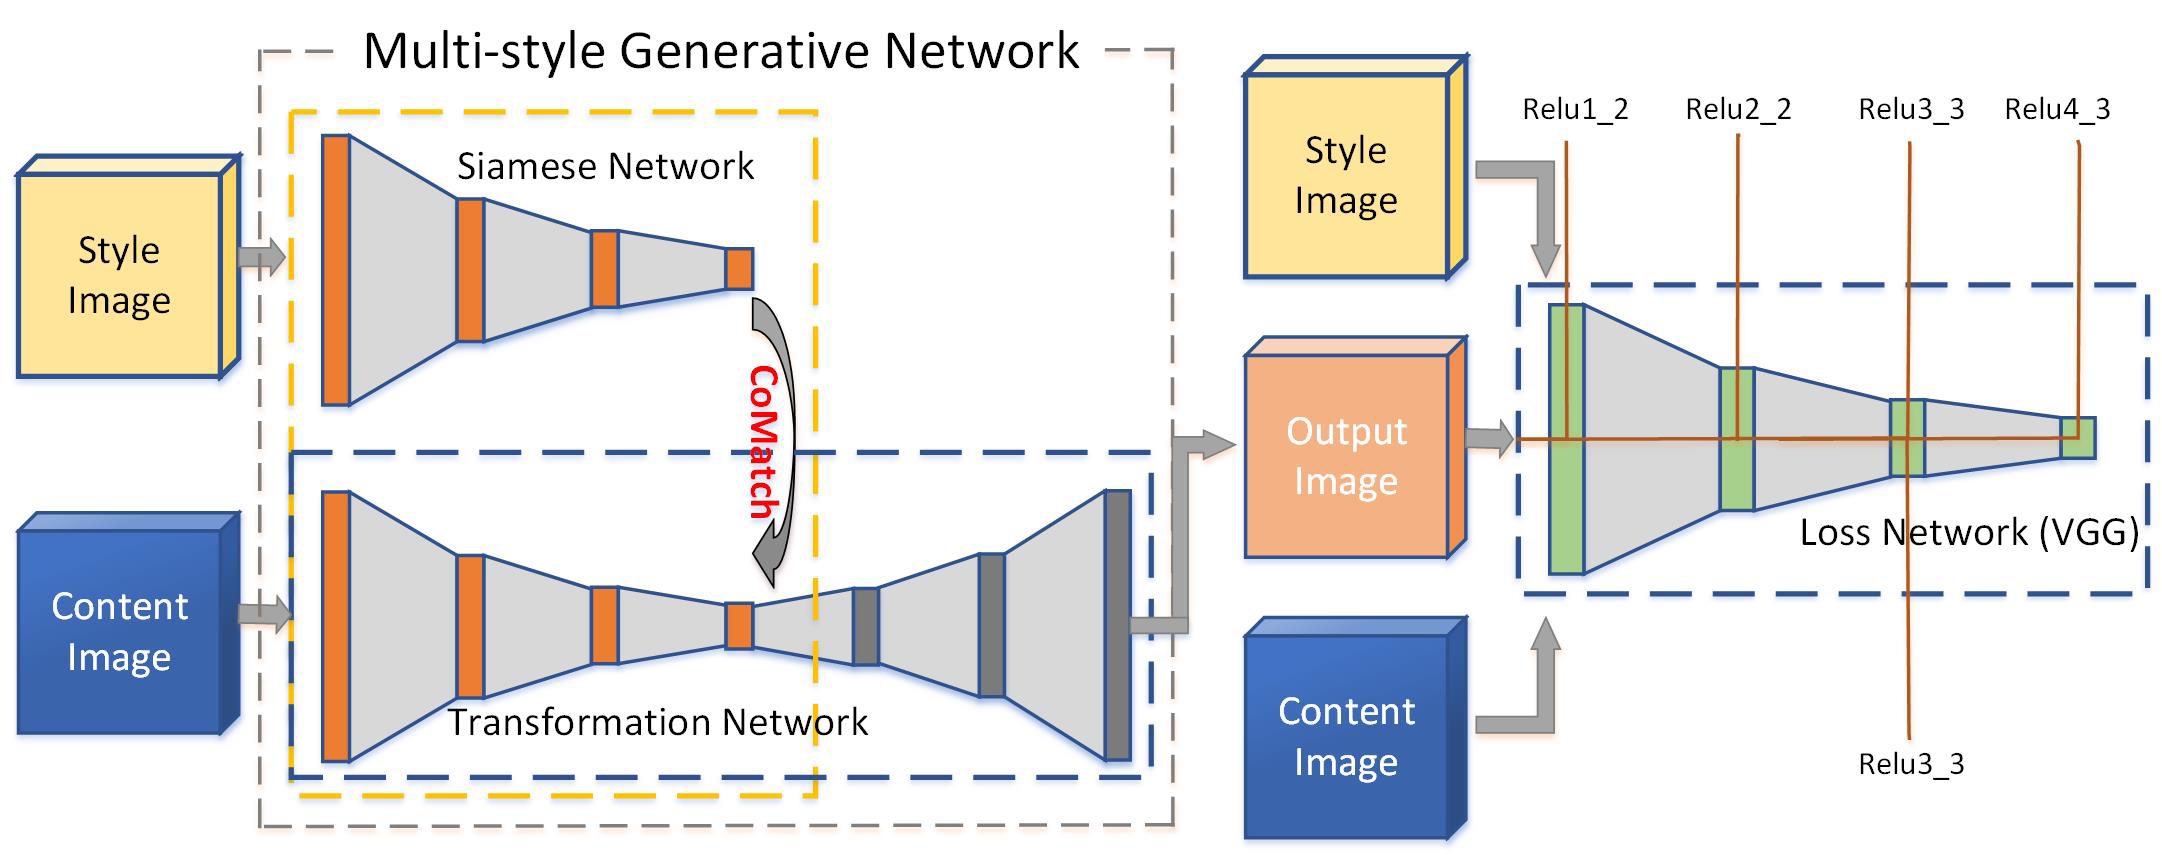
</div>

In [4]:
def train(epochs=3, batch_size=5, content_weight = 1.0, style_weight=100000.0):
    transform = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(256),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    train_dataset = datasets.ImageFolder('dataset_content', transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size)

    style_model = Net()
    
    if os.path.exists('msgnet_checkpoint.pth'):
        style_model.load_state_dict(torch.load('msgnet_checkpoint.pth'))
        
    style_model = style_model.cuda()
    style_model.train()
    
    optimizer = Adam(style_model.parameters(), 1e-3)
    mse_loss = torch.nn.MSELoss()

    vgg = Vgg16Featurer().cuda()

    style_loader = StyleLoader('dataset_style', 512, cuda=True)

    tbar = trange(epochs)
    for e in tbar:
        style_model.train()
        agg_content_loss = 0.
        agg_style_loss = 0.
        count = 0
        for batch_id, (x, _) in enumerate(train_loader):
            n_batch = len(x)
            count += n_batch
            optimizer.zero_grad()
            
            x = x.cuda()

            style_v = style_loader.get(batch_id)
            style_model.setTarget(style_v)

            features_style = vgg(style_v)
            gram_style = [gram_matrix(y) for y in features_style]

            y = style_model(x)
            xc = Variable(x.data.clone())

            features_y = vgg(y)
            features_xc = vgg(xc)

            f_xc_c = Variable(features_xc[1].data, requires_grad=False)

            content_loss = content_weight * mse_loss(features_y[1], f_xc_c)

            style_loss = 0.
            for m in range(len(features_y)):
                gram_y = gram_matrix(features_y[m])
                gram_s = Variable(gram_style[m].data, requires_grad=False).repeat(n_batch, 1, 1)
                style_loss += style_weight * mse_loss(gram_y, gram_s)

            total_loss = content_loss + style_loss
            total_loss.backward()
            optimizer.step()
            
            agg_content_loss += content_loss.data
            agg_style_loss += style_loss.data

            if (batch_id + 1) % 23 == 0:
                from IPython.display import clear_output
                clear_output(wait=True)
                mesg = "{} | Epoch {}: [{}/{}] | content: {:.3f}/{:.3f}, style: {:.3f}/{:.3f}, total: {:.3f}".format(
                    time.ctime(), e + 1, count, len(train_dataset),
                                content_loss.item(), agg_content_loss / (batch_id + 1),
                                style_loss.item(), agg_style_loss / (batch_id + 1),
                                (agg_content_loss + agg_style_loss) / (batch_id + 1)
                )
                tbar.set_description(mesg)
                grid_show([(style_v[0].detach()[:,::2,::2], 'Стиль'), (x[0].detach(), 'Контент'), (y[0].detach(), 'Результат')])
                plt.show()
                
            if (batch_id + 1) % 10000 == 0:
                style_model.eval()
                style_model = style_model.cpu()
                torch.save(style_model.state_dict(), 'msgnet_checkpoint.pth')
                style_model = style_model.cuda()
                style_model.train()

            
    style_model.eval()
    style_model.cpu()
    save_model_path = 'msgnet.pth'
    torch.save(style_model.state_dict(), save_model_path)

    print("\nВсё получилось! ;-) Модель здесь:", save_model_path)

Запустим 3 эпохи на ~1200000 картинках из CoCo датасета и 22 стилевых, составленных из разных картин.

Wed Jun 24 15:00:07 2020 | Epoch 3: [123280/123287] | content: 8.899/7.629, style: 2.788/5.058, total: 12.687:  67%|▋| 

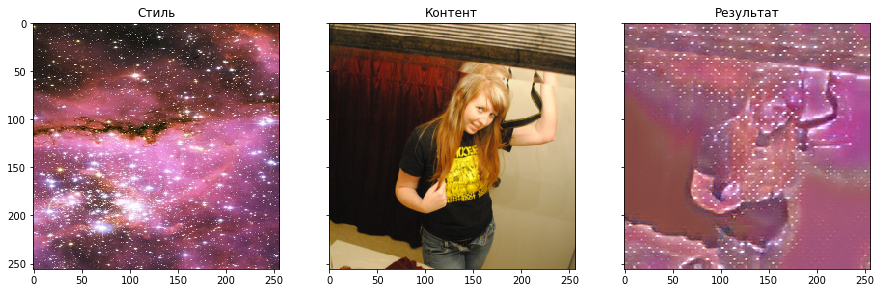

Wed Jun 24 15:00:07 2020 | Epoch 3: [123280/123287] | content: 8.899/7.629, style: 2.788/5.058, total: 12.687: 100%|█| 



Всё получилось! ;-) Модель здесь: msgnet.pth


In [5]:
train()